In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [2]:
bureau = pd.read_csv('dseb63_final_project_DP_dataset/dseb63_bureau.csv')
bb = pd.read_csv('dseb63_final_project_DP_dataset/dseb63_bureau_balance.csv')
train = pd.read_csv('dseb63_final_project_DP_dataset/dseb63_application_train.csv', index_col=0)

# 1 - Merge Data

In [3]:
bureau_agg = pd.merge(bureau, train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
bureau_agg.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629,0.0
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629,0.0
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629,0.0
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629,0.0
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629,0.0


In [4]:
bureau_and_bb = pd.merge(bureau_agg, bb, on='SK_ID_BUREAU', how='left')

In [7]:
bureau_and_bb.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629,0.0,NaN,NaN
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629,0.0,NaN,NaN
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629,0.0,NaN,NaN
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629,0.0,NaN,NaN
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629,0.0,NaN,NaN


In [9]:
def display_missing_data_info(dataframe):
    missing_values_count = dataframe.isnull().sum()
    missing_values_percentage = (dataframe.isnull().mean() * 100)
    missing_data = pd.DataFrame({
        'Missing Values': missing_values_count,
        'Percentage (%)': missing_values_percentage
    })
    
    missing_data = missing_data[missing_data['Missing Values'] > 0]
    
    sorted_missing_data = missing_data.sort_values(by='Missing Values')

    print(sorted_missing_data)

b_miss = display_missing_data_info(bureau)

                        Missing Values  Percentage (%)
AMT_CREDIT_SUM                       3        0.000205
DAYS_CREDIT_ENDDATE              89098        6.080426
AMT_CREDIT_SUM_DEBT             223094       15.224882
AMT_CREDIT_SUM_LIMIT            489670       33.417160
DAYS_ENDDATE_FACT               544673       37.170798
AMT_CREDIT_MAX_OVERDUE          948545       64.732738
AMT_ANNUITY                    1130013       77.116885


# 2 - HANDLE MISSING VALUES

In [12]:
bureau_and_bb['AMT_CREDIT_SUM'].fillna(bureau_and_bb['AMT_CREDIT_SUM'].median(), inplace=True)

bureau_and_bb['DAYS_CREDIT_ENDDATE'].fillna(bureau_and_bb['DAYS_CREDIT_ENDDATE'].median(), inplace=True)

# giả sử missing values là các khoản vay đã được thay toán hoàn toàn
bureau_and_bb['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)  

# giả sử missing values là những người không có giới hạn tín dụng 
bureau_and_bb['AMT_CREDIT_SUM_LIMIT'].fillna(0, inplace=True)  

# giả sử missing values là các khoản vay vẫn còn đang hoạt động
bureau_and_bb['DAYS_ENDDATE_FACT'].fillna(99999, inplace=True)

# giả sử missing values là các khoản vay không có lịch sử quá hạn thanh toán
bureau_and_bb['AMT_CREDIT_MAX_OVERDUE'].fillna(0, inplace=True) 

# 3 - ULTIS FUNCTION

In [13]:
def plot_count_by_target_bar(df, columns, target):
    for col in columns:
        plt.figure(figsize=(10, 6)) 
        sns.countplot(data=df, x=col, hue=target)
        plt.xticks(rotation=45)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

In [14]:
def plot_count_by_target_barh(df, columns, target):
    for col in columns:
        plt.figure(figsize=(9, 6)) 
        order = df[col].value_counts().index
        sns.countplot(data=df, y=col, hue=target, order=order)
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

In [15]:
def plot_count_distribution(dataframe, data_column, title=None, x_label=None, y_label=None):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=data_column, data=dataframe, order=dataframe[data_column].value_counts().index)
    
    if title is None:
        title = f'Distribution of {data_column}'
    plt.title(title)
    
    if x_label is None:
        x_label = 'Count'
    plt.xlabel(x_label)
    
    if y_label is None:
        y_label = data_column
    plt.ylabel(y_label)
    
    plt.show()

In [16]:
def plot_distribution_by_target(data, column, target_column ='TARGET'):
    plt.figure(figsize=(10, 8))
    
    sns.kdeplot(data.loc[data[target_column] == 0, column], label=f'{target_column} == 0', color='blue')
    sns.kdeplot(data.loc[data[target_column] == 1, column], label=f'{target_column} == 1', color='red')
    
    x_label = column
    
    plt.xlabel(x_label)
    plt.ylabel('Density')
    plt.title(f'Distribution of {x_label}')
    plt.legend()
    plt.show()

# 4 - CATEGORICAL VARIABLES 

## 4.1. CREDIT_TYPE

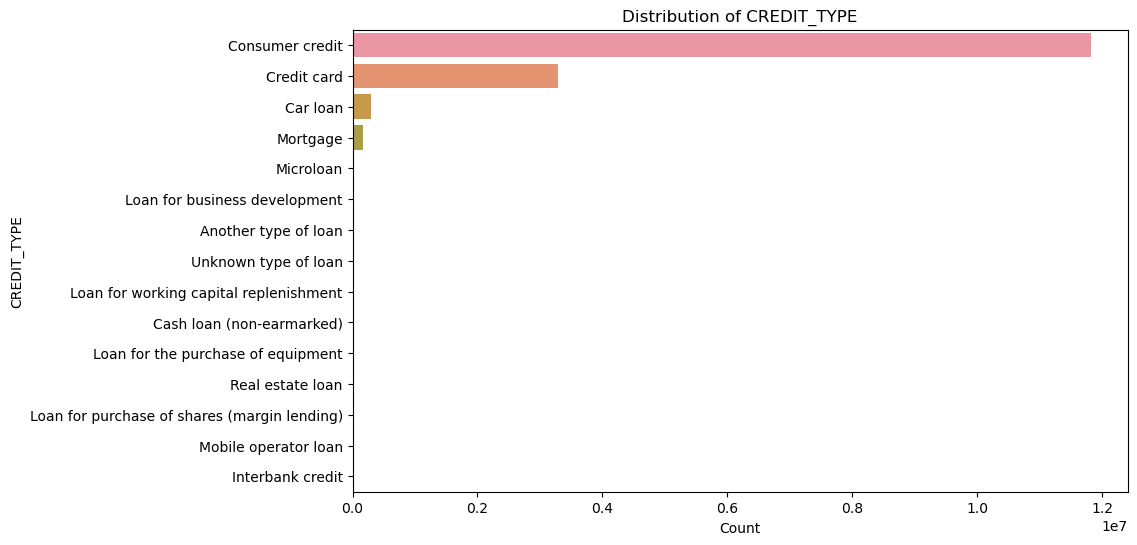

In [17]:
plot_count_distribution(bureau_and_bb, 'CREDIT_TYPE')

- Cột 'CREDIT_TYPE' chứa nhiều loại tín dụng khác nhau, nhưng một số loại chỉ xuất hiện vài lần. Để đơn giản hóa dữ liệu và tránh các vấn đề khi một số loại tín dụng có quá ít thông tin để phân tích, hãy thay thế tất cả các loại tín dụng bằng một danh mục duy nhất là 'Rare', ngoại trừ 'Consumer credit' và 'Credit card'.

In [21]:
bureau_and_bb['CREDIT_TYPE'] = bureau_and_bb['CREDIT_TYPE'].replace(['Car loan',
            'Mortgage',
            'Microloan',
            'Loan for business development', 
            'Another type of loan',
            'Unknown type of loan', 
            'Loan for working capital replenishment',
            "Loan for purchase of shares (margin lending)",                                                
            'Cash loan (non-earmarked)', 
            'Real estate loan',
            "Loan for the purchase of equipment", 
            "Interbank credit", 
            "Mobile operator loan"], 'Rare')

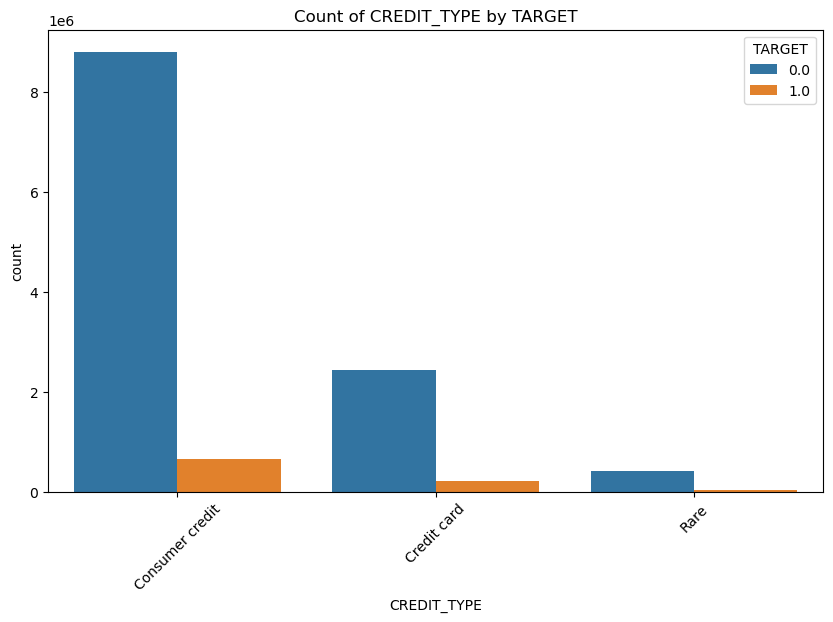

In [22]:
plot_count_by_target_bar(bureau_and_bb, ['CREDIT_TYPE'], 'TARGET')

## 4.2. CREDIT_ACTIVE

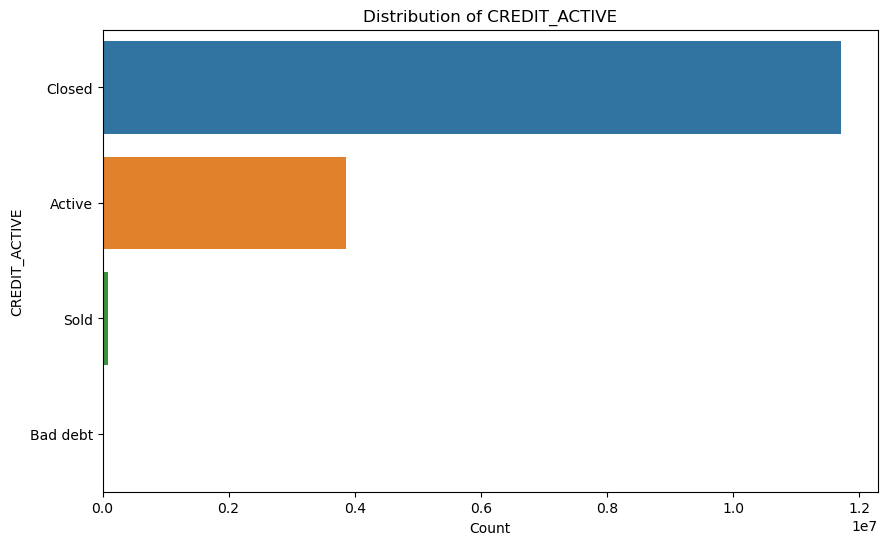

In [23]:
plot_count_distribution(bureau_and_bb, 'CREDIT_ACTIVE')

- CREDIT_ACTIVE có 4 giá trị: Closed, Active, Sold, Bad Dept
- Sold, Bad Dept có vẻ không liên quan lắm, nên thay bằng active

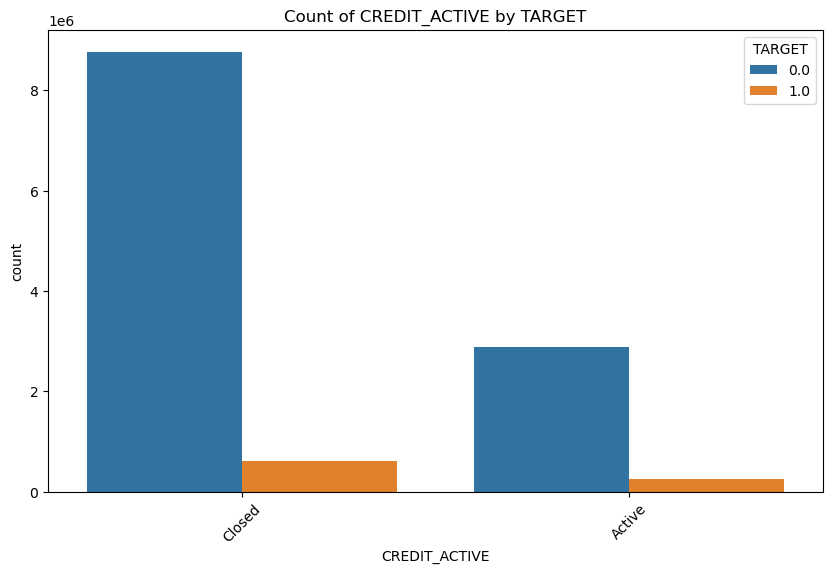

In [24]:
bureau_and_bb['CREDIT_ACTIVE'] = bureau_and_bb['CREDIT_ACTIVE'].replace(['Bad debt','Sold'], 'Active')
plot_count_by_target_bar(bureau_and_bb, ['CREDIT_ACTIVE'], 'TARGET')

## 4.3. CREDIT_CURRENCY

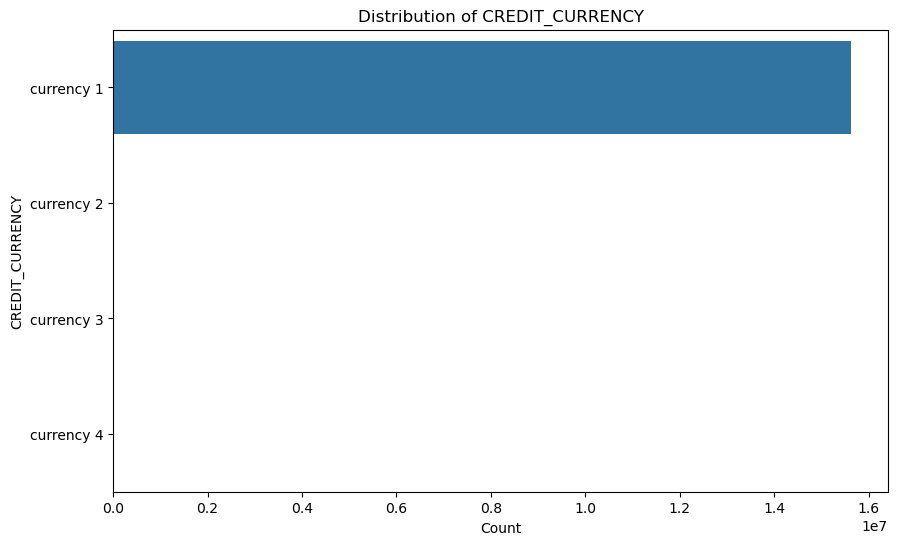

In [25]:
plot_count_distribution(bureau_and_bb, 'CREDIT_CURRENCY')

- Xóa các cột 'SK_ID_BUREAU' và 'CREDIT_CURRENCY' khỏi dataframe vì cột 'CREDIT_CURRENCY' có 99.9% giá trị là 'currency 1', và cột 'SK_ID_BUREAU' không còn quan trọng cho việc phân tích.

In [26]:
bureau_and_bb.drop(["SK_ID_BUREAU","CREDIT_CURRENCY"], inplace = True, axis = 1)

# 5 - NUMERICAL VARIABLES 

## 5.0. Function

In [27]:
def plot_histogram(data, column, hue="TARGET", bins=None, kde=True):
    if bins is None:
        num_bins = int(1 + np.log2(len(data)))
    else:
        num_bins = bins
    sns.histplot(data=data, x=column, hue=hue, bins=num_bins, kde=kde)

In [28]:
def draw_distribution_dist(x, title,c):
    fig, ax = plt.subplots(2,1,figsize=(10,5))

    sns.distplot(x,ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')

    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

In [29]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'countplot', 'box'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''
    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='blue')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='red')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot, palette={'0.0': 'blue', '1.0': 'red'})
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
                
        if ele == 'countplot':
            sns.countplot(data_to_plot[column_name],hue=data_to_plot['TARGET'])
#             ax.set_xticklabels(ax.get_xticklabels(), rotation= 60)
#             plt.show()

    plt.show()

## 5.1. YEARS_CREDIT

In [30]:
bureau_and_bb['YEARS_CREDIT'] = abs(bureau_and_bb['DAYS_CREDIT'] / 365)

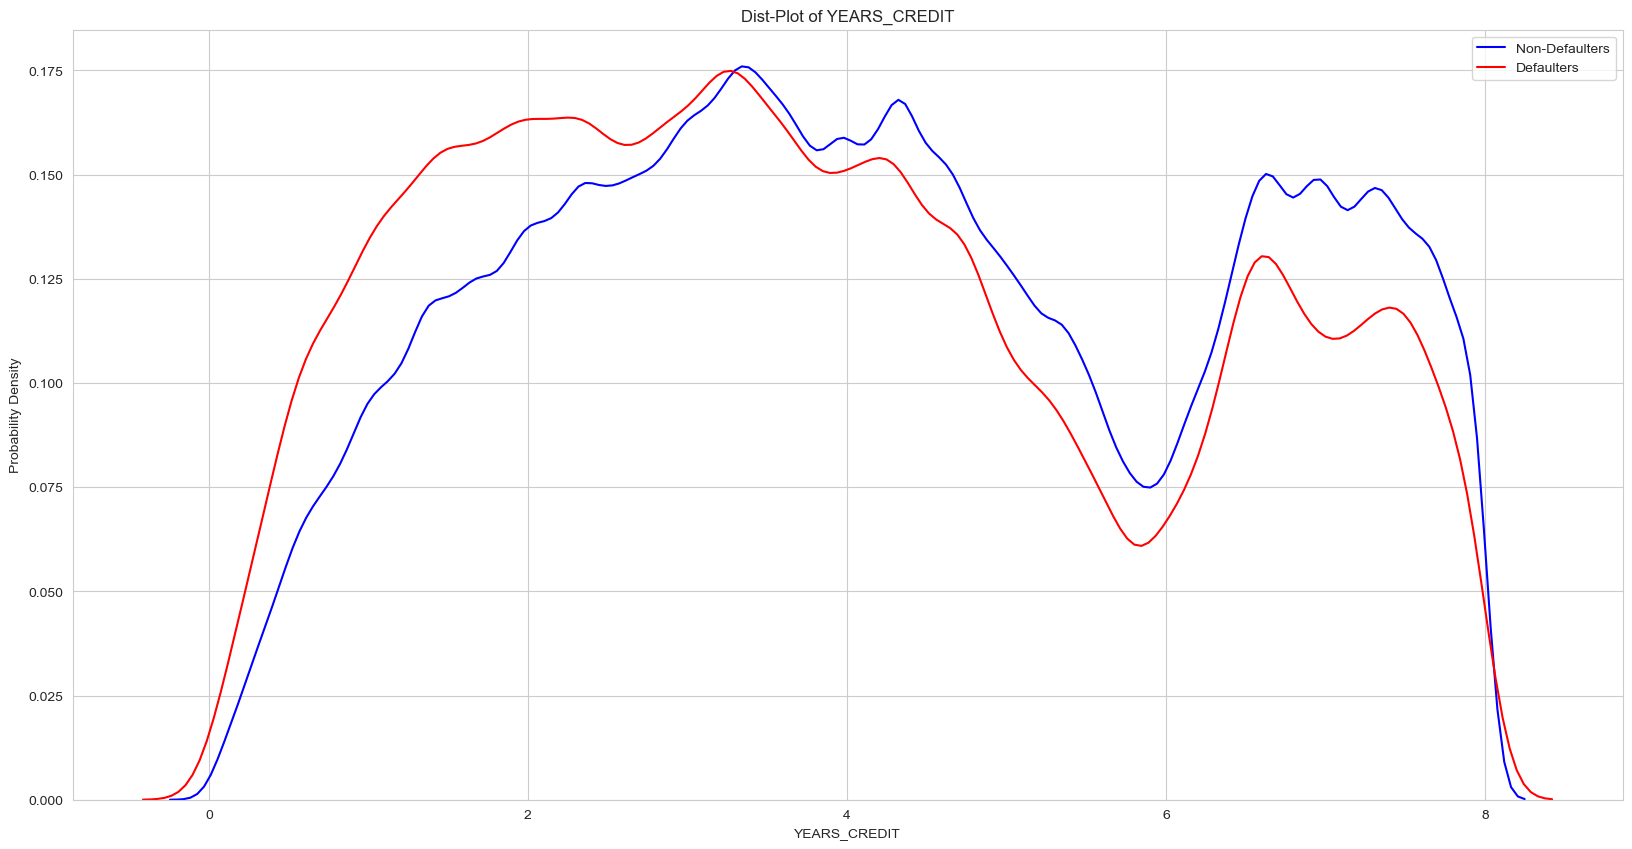

In [31]:
plot_continuous_variables(bureau_and_bb,'YEARS_CREDIT', plots = ['distplot'],figsize=(20,10))

- Cả nhóm khách hàng mặc định và không mặc định đều có phân bố số năm tín dụng tương tự nhau, với đỉnh của phân bố nằm trong cùng một khoảng.
- Điều này có thể cho thấy rằng số năm tín dụng không cung cấp đủ khả năng phân biệt để dự đoán khả năng mặc định.
- Nhóm không mặc định có khoảng tứ phân vị (IQR) hẹp hơn so với nhóm mặc định, điều này có thể gợi ý rằng những người không mặc định thường có lịch sử tín dụng ổn định hơn.- 
Không có sự khác biệt đáng kể về số năm tín dụng trung bình giữa hai nhóm.

## 5.2. DAYS_CREDIT_ENDDATE

In [35]:
bureau_and_bb[['DAYS_CREDIT_ENDDATE', 'TARGET']]

,DAYS_CREDIT_ENDDATE,TARGET
0,-153.0,0.0
1,1075.0,0.0
2,528.0,0.0
3,-838.0,0.0
4,1197.0,0.0
...,...,...
15643417,-2511.0,0.0
15643418,-2511.0,0.0
15643419,-2511.0,0.0
15643420,-2511.0,0.0


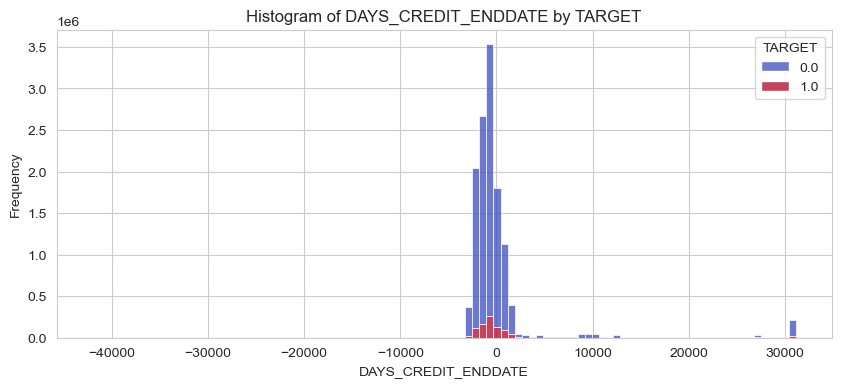

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=bureau_and_bb, x='DAYS_CREDIT_ENDDATE', hue='TARGET', multiple='stack', palette='coolwarm', bins= 100)

plt.title('Histogram of DAYS_CREDIT_ENDDATE by TARGET')
plt.xlabel('DAYS_CREDIT_ENDDATE')
plt.ylabel('Frequency')

plt.show()


- chúng ta thấy có vẻ như có giá trị sai lệch đối với DAYS_CREDIT_ENDDATE, khi giá trị phân vị 0 lại kéo dài đến 42060 ngày, tương đương với 115 năm. Điều này không hợp lý vì nó có nghĩa là khoản vay trước đó của khách hàng đã tồn tại cách đây 115 năm. Đây có thể là khoản vay thừa kế, nhưng chúng ta không thể khẳng định chắc chắn về điều đó. Chúng ta sẽ cố gắng loại bỏ những giá trị này trong giai đoạn tiền xử lý dữ liệu.

## 5.3. AMT_CREDIT_SUM

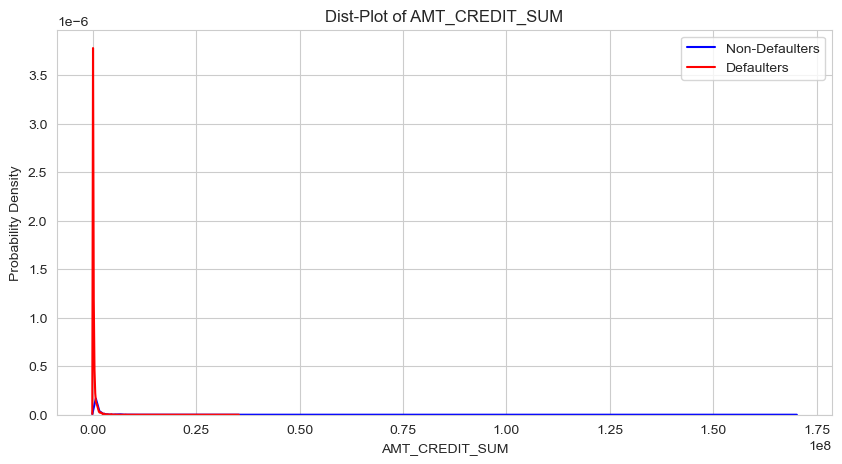

In [49]:
plot_continuous_variables(bureau_and_bb,'AMT_CREDIT_SUM', plots = ['distplot'],figsize=(10,5))

## 5.4. CREDIT_DEBT_RATIO

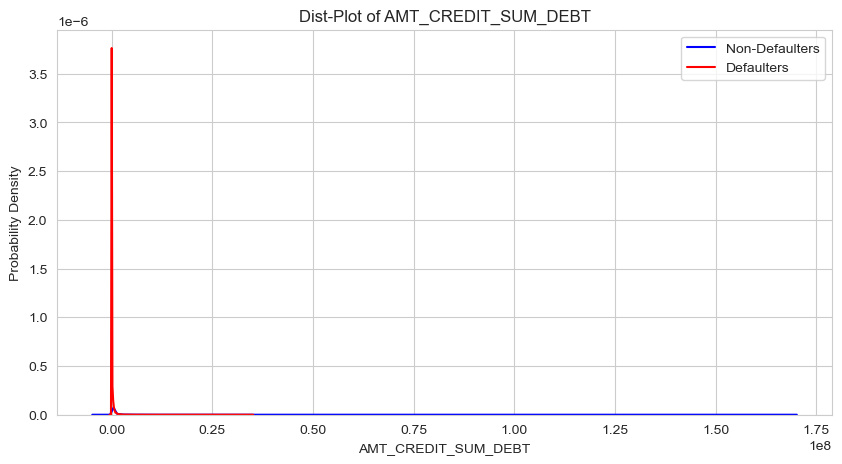

In [50]:
plot_continuous_variables(bureau_and_bb,'AMT_CREDIT_SUM_DEBT', plots = ['distplot'],figsize=(10,5))

# 6. BEREAU BALANCE

## 6.1. STATUS

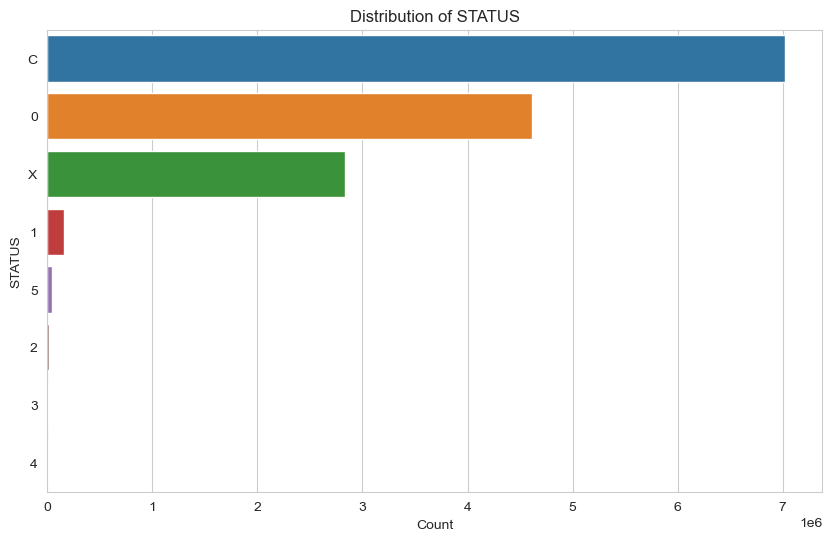

In [51]:
plot_count_distribution(bureau_and_bb, 'STATUS')

In [52]:
status_df = bureau_and_bb.groupby(['SK_ID_CURR', 'TARGET']).agg({'STATUS': 'nunique'}).reset_index()
status_df.head()

,SK_ID_CURR,TARGET,STATUS
0,0,0.0,0
1,1,1.0,2
2,2,0.0,0
3,3,0.0,0
4,4,0.0,0


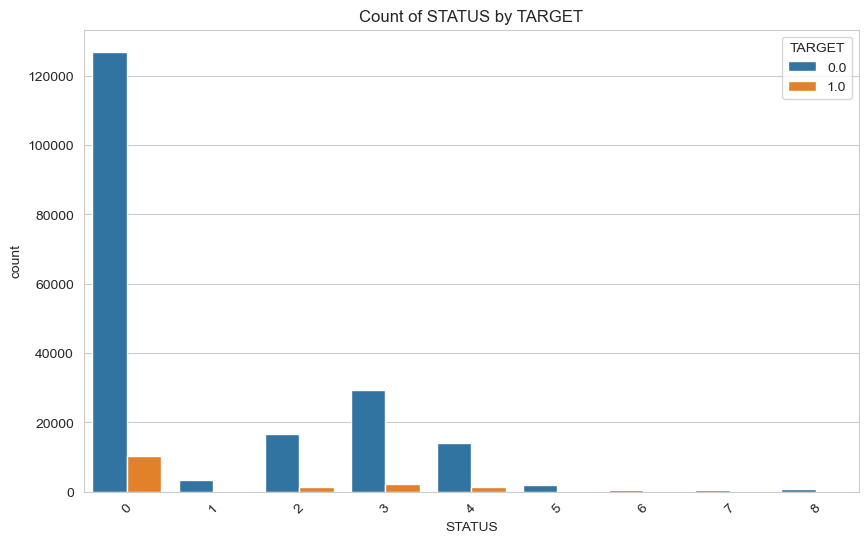

In [53]:
plot_count_by_target_bar(status_df, ['STATUS'], 'TARGET')

In [54]:
df_copy = bureau_and_bb.copy()

df_dummies = pd.get_dummies(df_copy['STATUS'], prefix='STATUS', dummy_na=True)

selected_dummies = df_dummies[['STATUS_0', 'STATUS_C']]

bureau_and_bb = pd.concat([bureau_and_bb, selected_dummies], axis=1)
status_0_sum_df = bureau_and_bb.groupby(['SK_ID_CURR', 'TARGET'])['STATUS_0'].sum().reset_index()
status_0_sum_df

,SK_ID_CURR,TARGET,STATUS_0
0,0,0.0,0
1,1,1.0,10
2,2,0.0,0
3,3,0.0,0
4,4,0.0,0
...,...,...,...
210804,307501,0.0,17
210805,307504,0.0,0
210806,307505,0.0,15
210807,307506,0.0,0


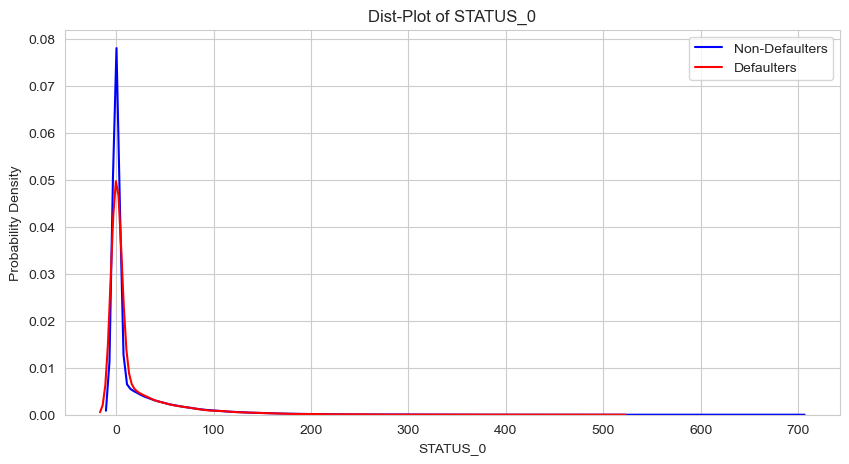

In [56]:
plot_continuous_variables(status_0_sum_df ,'STATUS_0', plots = ['distplot'],figsize=(10,5))

## 6.2. MONTHS_BALANCE

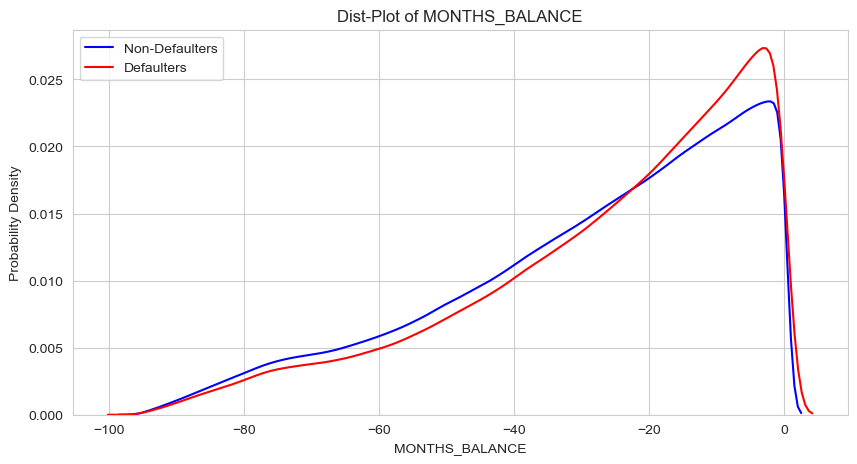

In [58]:
plot_continuous_variables(bureau_and_bb, 'MONTHS_BALANCE', plots=['distplot'], figsize=(10,5))

- Cả hai biểu đồ đều cho thấy không có sự phân biệt rõ ràng giữa nhóm người mặc định và không mặc định chỉ dựa trên giá trị "MONTHS_BALANCE". Cả hai nhóm có phân bố tương tự nhau và các giá trị trung vị của chúng gần như giống hệt nhau.
- Có sự chồng lấn lớn giữa hai nhóm, điều này chỉ ra rằng "MONTHS_BALANCE" có thể không phải là một biến độc lập mạnh để dự đoán khả năng mặc định của khách hàng.